### meteostat  test 

In [1]:
#!pip install meteostat

In [2]:
import pandas as pd
import numpy as np
import meteostat as mt
import matplotlib.pyplot as plt
import datetime

In [3]:
solar_site_posn = (53.6985, -6.2080)  # Bettystown, Ireland
latitude, longitude = solar_site_posn
# Set time period
start_date = datetime.datetime.strptime("2024-09-10 00:00:00","%Y-%m-%d %H:%M:%S")
end_date = datetime.datetime.strptime("2025-11-10 00:00:00","%Y-%m-%d %H:%M:%S")
print(f"Start_Time: {start_date}  End {end_date}")

Start_Time: 2024-09-10 00:00:00  End 2025-11-10 00:00:00


In [7]:
# Get nearby weather stations

stations = mt.Stations()
# Get the stations near the specified latitude and longitude
stations = stations.nearby(latitude, longitude)
# Get the first station from the list , which is usually the closest one
df_station = stations.fetch(1)
# Reset index to access station ID
df_station.reset_index(inplace=True)
print(f"Station ID: {df_station['id'][0]}")
print(f"Station Name: {df_station['name'][0]}")
print(f"Station Distance: {df_station['distance'][0]:.2f} m")
# Get station ID
station_id = df_station['id'][0]

# Get hourly data
data = mt.Hourly(station_id, start_date, end_date,timezone='Europe/Dublin')
# fetch the data
weather_df = data.fetch()
# set index to default integer index
weather_df.reset_index(inplace=True)
# find all missing values in the dataframe
missing_values = weather_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)
# fix missing values by forward filling and then backward filling
weather_df.ffill(inplace=True)
weather_df.bfill(inplace=True)
# find all missing values in the dataframe
missing_values = weather_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)
# explode the dataframe time to 10 minute intervals
weather_df.set_index('time', inplace=True)
weather_df = weather_df.resample('10T').interpolate(method='linear')
weather_df.reset_index(inplace=True)
# we are only interested in time, temperature, humidity, and solar radiation
weather_df = weather_df[['time', 'temp', 'rhum', 'tsun']]
# now load the dataframe solar system data
#solar_df = pd.read_csv('solar_system_data.csv')
# merge the two dataframes on time

Station ID: 03969
Station Name: Dublin Airport
Station Distance: 29619.04 m
Missing values in each column:
time       0
temp       0
dwpt       0
rhum       0
prcp     312
snow    9813
wdir       0
wspd       0
wpgt       0
pres       0
tsun       0
coco       0
dtype: int64
Missing values in each column:
time    0
temp    0
dwpt    0
rhum    0
prcp    0
snow    0
wdir    0
wspd    0
wpgt    0
pres    0
tsun    0
coco    0
dtype: int64


         Date  Number      Time Working State  PV(W)  Battery(W)  Grid(W)  \
0  2024-09-12       1  00:00:00        Online    1.0     -115.72      6.0   
1  2024-09-12       2  00:05:00        Online    1.0     -210.00      0.0   
2  2024-09-12       3  00:10:00        Online    1.0     -199.50      1.0   
3  2024-09-12       4  00:15:00        Online    1.0     -199.50      0.0   
4  2024-09-12       5  00:20:00        Online    1.0     -194.25     77.0   

   Load(W)  SOC(%)  Total_Yield(kWh)  \
0      0.0    57.0              29.5   
1    211.0    57.0              29.5   
2      0.0    57.0              29.5   
3      0.0    56.0              29.5   
4      0.0    56.0              29.5   

                                    Source_File             DateTime  
0  Daily+Power+Station+Chart_19-11-2025 (1).xls  2024-09-12 00:00:00  
1  Daily+Power+Station+Chart_19-11-2025 (1).xls  2024-09-12 00:05:00  
2  Daily+Power+Station+Chart_19-11-2025 (1).xls  2024-09-12 00:10:00  
3  Daily+Pow

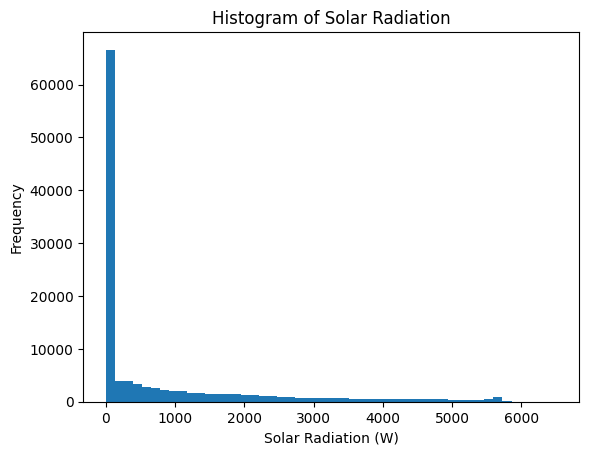

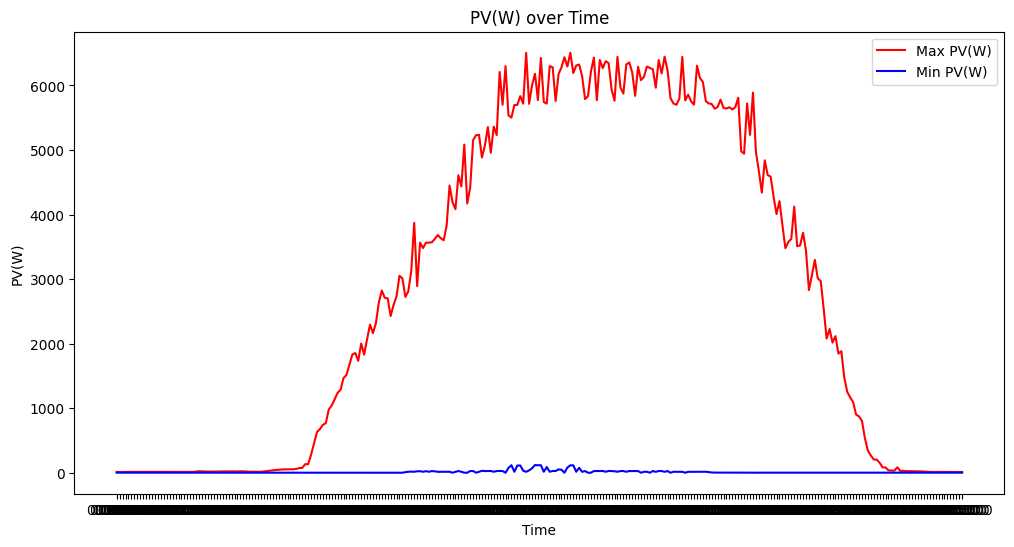

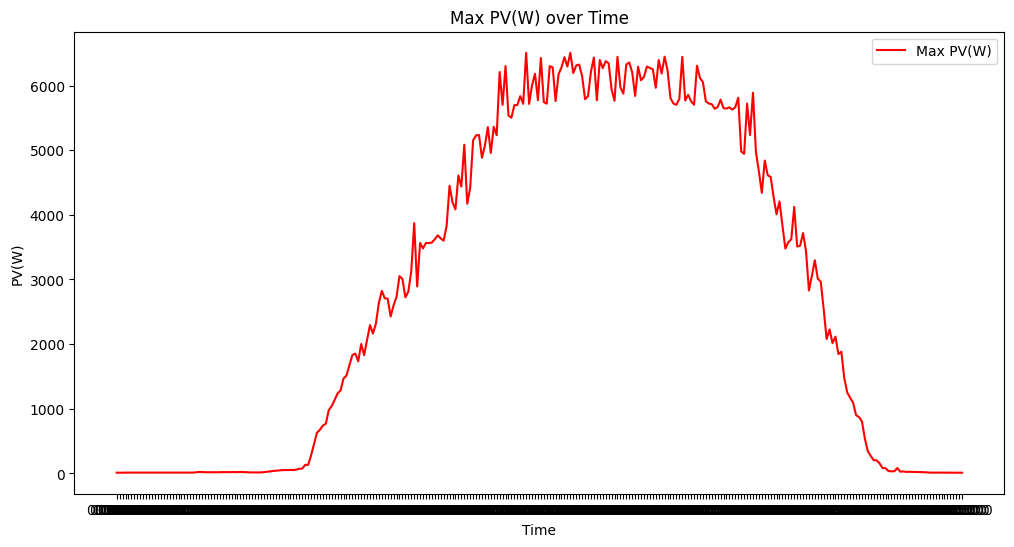

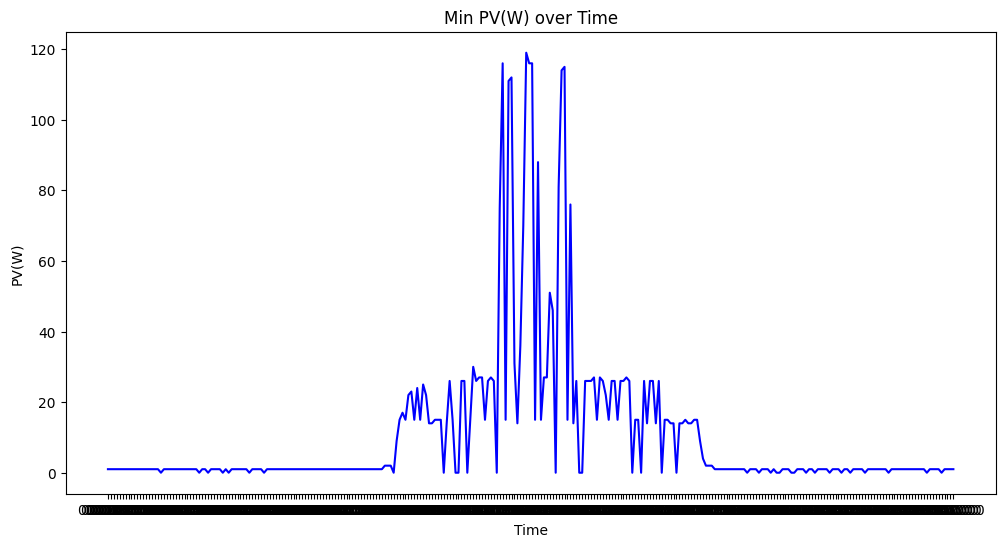

In [34]:
df_solar = pd.read_csv("C:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/processed_data/df_raw_daily_solar.csv")
print(df_solar.head())
# plot a histogram of the solar radiation
plt.hist(df_solar['PV(W)'], bins=50)
plt.xlabel('Solar Radiation (W)')
plt.ylabel('Frequency')
plt.title('Histogram of Solar Radiation')
# Plot PV(W) max and min by time
df_max_min = df_solar.groupby('Time')['PV(W)'].agg(['max', 'min']).reset_index()
plt.figure(figsize=(12, 6))

plt.xlabel('Time')
plt.ylabel('PV(W)')
plt.title('PV(W) over Time')
plt.plot(df_max_min['Time'], df_max_min['max'], label='Max PV(W)', color='red')
plt.plot(df_max_min['Time'], df_max_min['min'], label='Min PV(W)', color='blue')
plt.legend()
# Plot max only
plt.figure(figsize=(12, 6))
plt.plot(df_max_min['Time'], df_max_min['max'], label='Max PV(W)', color='red')
plt.xlabel('Time')
plt.ylabel('PV(W)')
plt.title('Max PV(W) over Time')
plt.legend()
# Plot min only
plt.figure(figsize=(12, 6))
plt.plot(df_max_min['Time'], df_max_min['min'], label='Min PV(W)', color='blue')
plt.xlabel('Time')
plt.ylabel('PV(W)')
plt.title('Min PV(W) over Time')
plt.show()

In [ ]:
# merge both dataframes on datetime
df_solar['DateTime'] = pd.to_datetime(df_solar['DateTime'])
# Remove timezone info from weather_df DateTime
weather_df['DateTime'] = pd.to_datetime(weather_df['time']).dt.tz_localize(None)
#print(df_solar.info())
#print(weather_df.info())
# merge both dataframes on DateTime
merged_df = pd.merge(df_solar[['DateTime','PV(W)']], weather_df, left_on='DateTime', right_on='DateTime', how='inner')
merged_df.drop(columns=['time'], inplace=True)
# Add month , day of year, hour of day columns
merged_df['Month'] = merged_df['DateTime'].dt.month.astype(float)
merged_df['Day_of_Year'] = merged_df['DateTime'].dt.dayofyear.astype(float)
merged_df['Hour_of_Day'] = merged_df['DateTime'].dt.hour.astype(float)
# Now normalize using sin days and month centered at the summer solstice
# Month normalization , hour of day normalization around noon
merged_df['Month_sin'] = np.sin(2 * np.pi * (merged_df['Month'] - 6) / 12)
merged_df['Hour_of_Day_sin'] = np.sin(2 * np.pi * (merged_df['Hour_of_Day'] - 12) / 24)
merged_df['Day_of_Year_sin'] = np.sin(2 * np.pi * (merged_df['Day_of_Year'] - 172) / 365)
# Rename columns for clarity
merged_df.rename(columns={'temp': 'Temperature(C)', 'rhum': 'Relative_Humidity(%)', 'tsun': 'Solar_Radiation(W/m2)'}, inplace=True)
# Head of merged dataframe
print(merged_df.head())

             DateTime  PV(W)  Temperature(C)  Relative_Humidity(%)  \
0 2024-09-12 00:00:00    1.0             7.1                  90.0   
1 2024-09-12 00:10:00    1.0        7.066667             90.166667   
2 2024-09-12 00:20:00    1.0        7.033333             90.333333   
3 2024-09-12 00:30:00    1.0             7.0                  90.5   
4 2024-09-12 00:40:00    1.0        6.966667             90.666667   

   Solar_Radiation(W/m2)     Month  Day_of_Year  Hour_of_Day  
0                    0.0  0.727273      0.69863          0.0  
1                    0.0  0.727273      0.69863          0.0  
2                    0.0  0.727273      0.69863          0.0  
3                    0.0  0.727273      0.69863          0.0  
4                    0.0  0.727273      0.69863          0.0  


In [24]:
# Shoe the first 5 rows of the merged dataframe
print(merged_df.head())

             DateTime  PV(W)  Temperature(C)  Relative_Humidity(%)  \
0 2024-09-12 00:00:00    1.0             7.1                  90.0   
1 2024-09-12 00:10:00    1.0        7.066667             90.166667   
2 2024-09-12 00:20:00    1.0        7.033333             90.333333   
3 2024-09-12 00:30:00    1.0             7.0                  90.5   
4 2024-09-12 00:40:00    1.0        6.966667             90.666667   

   Solar_Radiation(W/m2)  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  


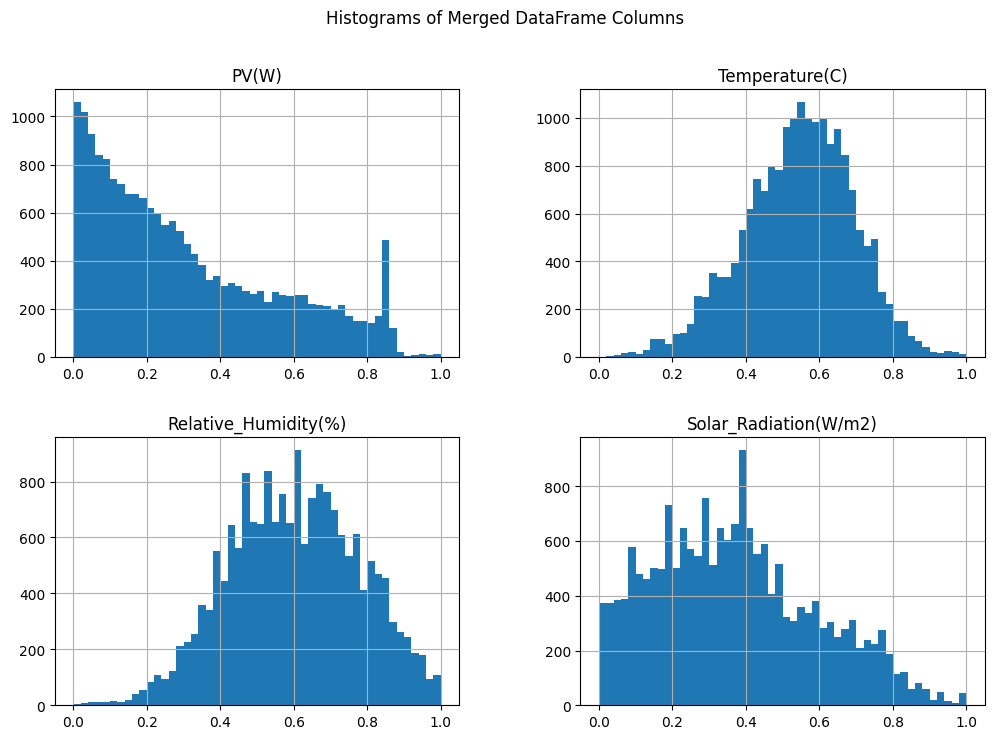

In [47]:
# Do a histogram of of all the merged dataframe columns except DateTime
merged_df.hist(column=['PV(W)', 'Temperature(C)', 'Relative_Humidity(%)', 'Solar_Radiation(W/m2)'], bins=50, figsize=(12, 8))
plt.suptitle('Histograms of Merged DataFrame Columns')
plt.show()

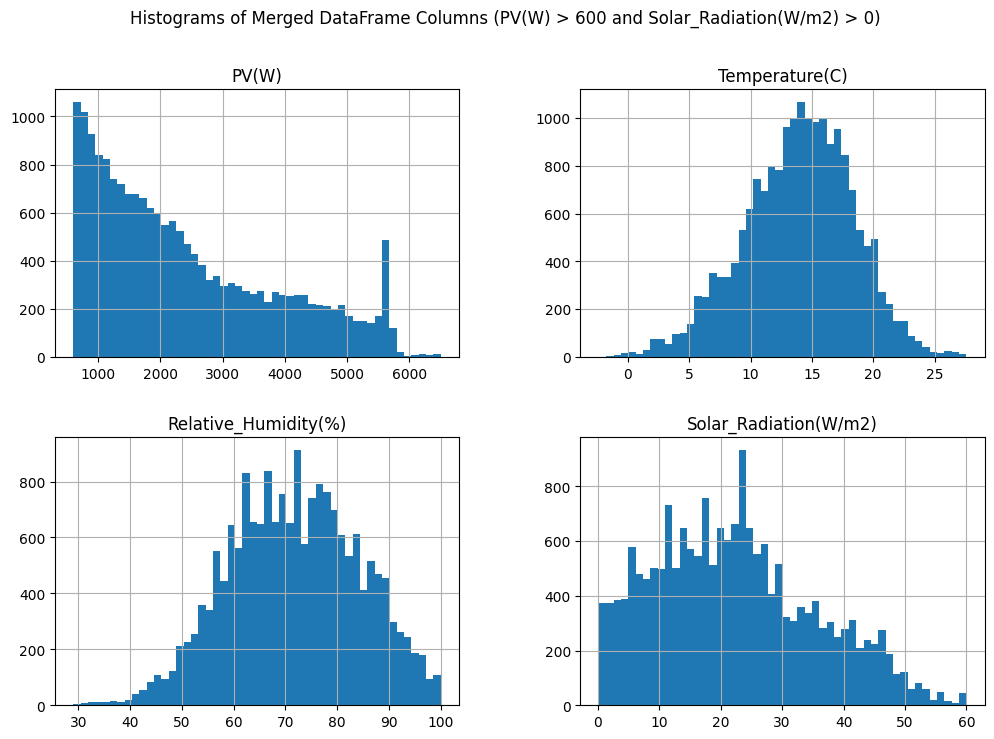

In [32]:
# remove all rows which have PV(W) less than or equal to 0 because that is at night time
merged_df = merged_df[merged_df['PV(W)'] > 600]
# Solar Radiation should also be greater than 0
merged_df = merged_df[merged_df['Solar_Radiation(W/m2)'] > 0]
# do histogram again
merged_df.hist(column=['PV(W)', 'Temperature(C)', 'Relative_Humidity(%)', 'Solar_Radiation(W/m2)'], bins=50, figsize=(12, 8))
plt.suptitle('Histograms of Merged DataFrame Columns (PV(W) > 600 and Solar_Radiation(W/m2) > 0)')
plt.show()

In [39]:
# Normalize the data using Min-Max scaling
# check if scikit-learn is installed , only needed in Jupyter notebooks
#!pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merged_df[['PV(W)', 'Temperature(C)', 'Relative_Humidity(%)', 'Solar_Radiation(W/m2)']] = scaler.fit_transform(merged_df[['PV(W)', 'Temperature(C)', 'Relative_Humidity(%)', 'Solar_Radiation(W/m2)']])
print(merged_df.head())

              DateTime     PV(W)  Temperature(C)  Relative_Humidity(%)  \
46 2024-09-12 07:50:00  0.006434        0.308120              0.917840   
47 2024-09-12 08:00:00  0.055706        0.312570              0.915493   
48 2024-09-12 08:10:00  0.083474        0.322581              0.896714   
49 2024-09-12 08:20:00  0.105317        0.332592              0.877934   
50 2024-09-12 08:30:00  0.123264        0.342603              0.859155   

    Solar_Radiation(W/m2)  
46               0.164345  
47               0.197772  
48               0.231198  
49               0.264624  
50               0.298050  


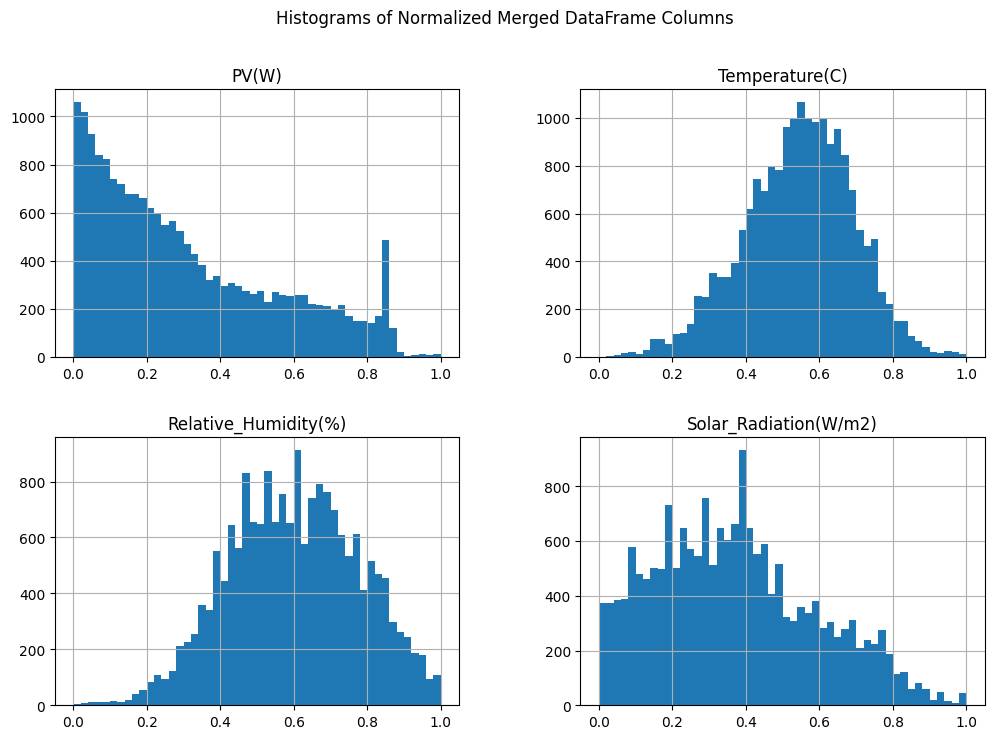

In [42]:
# historgram the normalized data
merged_df.hist(column=['PV(W)', 'Temperature(C)', 'Relative_Humidity(%)', 'Solar_Radiation(W/m2)'], bins=50, figsize=(12, 8))
plt.suptitle('Histograms of Normalized Merged DataFrame Columns')
plt.show()

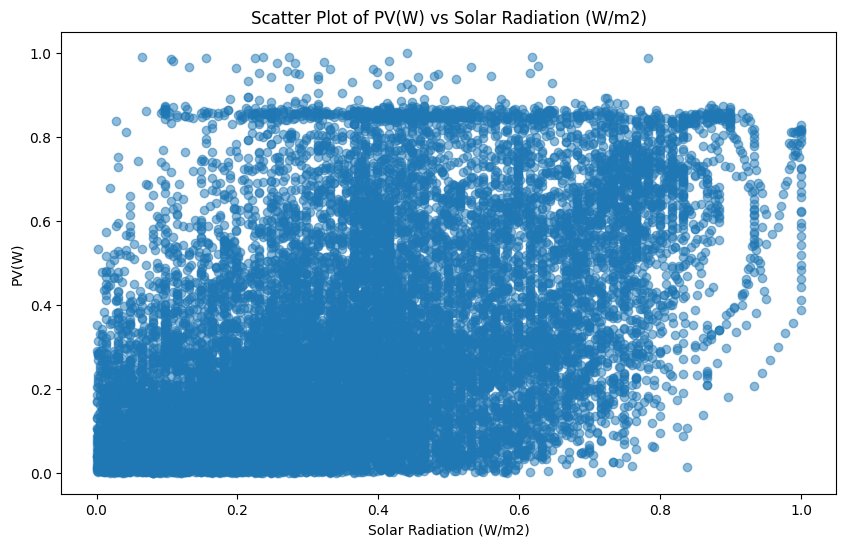

In [43]:
# plot a scatter plot of PV(W) vs Solar_Radiation(W/m2)
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Solar_Radiation(W/m2)'], merged_df['PV(W)'], alpha=0.5)
plt.xlabel('Solar Radiation (W/m2)')
plt.ylabel('PV(W)')
plt.title('Scatter Plot of PV(W) vs Solar Radiation (W/m2)')
plt.show()

Mean Squared Error: 0.03403461618984539
R^2 Score: 0.4530598941416526
Feature: Temperature(C), Importance: 0.30100184394980567
Feature: Relative_Humidity(%), Importance: 0.40526147122333706
Feature: Solar_Radiation(W/m2), Importance: 0.2937366848268573


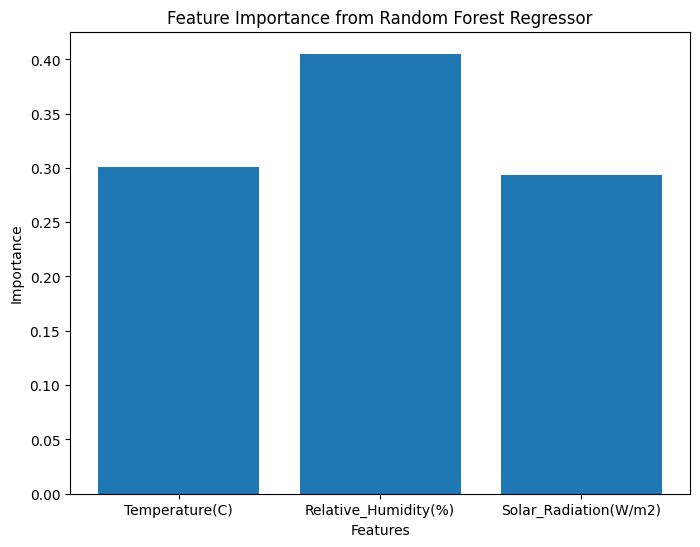

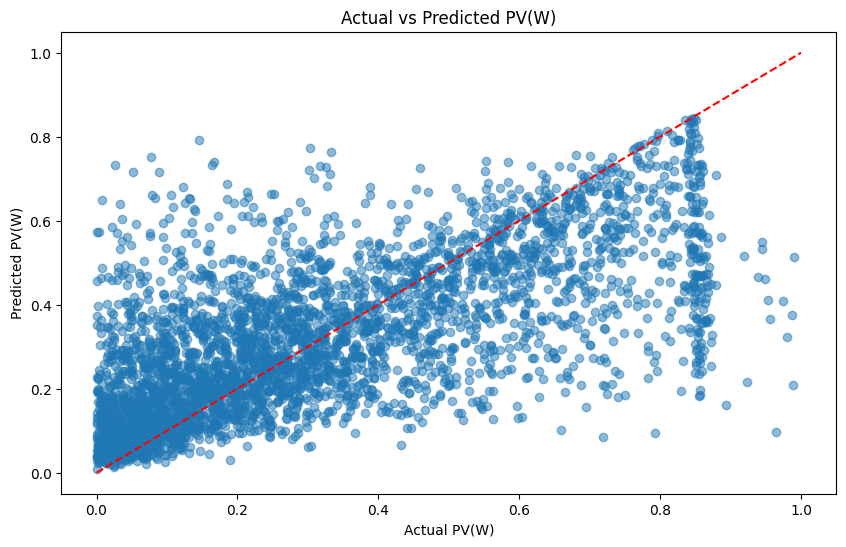

In [45]:
# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Define features and target variable
X = merged_df[['Temperature(C)', 'Relative_Humidity(%)', 'Solar_Radiation(W/m2)']]
y = merged_df['PV(W)']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model
rf_model.fit(X_train, y_train)
# Make predictions
y_pred = rf_model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
# Feature importance
importances = rf_model.feature_importances_
feature_names = X.columns
for feature, importance in zip(feature_names, importances):
    print(f"Feature: {feature}, Importance: {importance}")  
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest Regressor')
plt.show()
# how good is the prediction
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual PV(W)')
plt.ylabel('Predicted PV(W)')
plt.title('Actual vs Predicted PV(W)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.show()